In [1]:
from IPython.display import Image

Image(url="data.png", width=700, height=500)

**Генерация данных**


Воспользуясь формулой стандартизации:
$Z = (x - \mu)/ \sigma$

Получим:

$\sigma = \sqrt(pe) \rightarrow N(0, pe) = \sqrt(pe) \cdot N(0, 1)$

Также запись: $1^T \cdot X_{inv} = [1, 1] \cdot [x_{inv_1}; x_{inv_2}] = x_{inv_1} + x_{inv_2}$

In [2]:
import numpy as np
import torch

np.random.seed(50)
def generate_data(pe, n_samples):
    x_inv = np.random.randn(n_samples, 2)
    Y = x_inv.sum() + 0.1 * np.random.randn(n_samples, 1)
    x_env = np.column_stack([Y, Y]) + np.sqrt(pe) * np.random.randn(n_samples, 2)
    X = np.hstack([x_inv, x_env])
    return X,  Y


/home/master/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Организация датасетов**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

pe_train = [0.1, 0.3, 0.5, 0.7, 0.9]
pe_val = [0.4, 0.8]
pe_test = [10.0, 100.0]
count = 200
batch_size = 16

np.random.seed(50)

def create_dataloader(pe, count, batch_size):
    res_X, res_Y = np.array([[0, 0, 0, 0]]), np.array([0])
    for p in pe:
        X, Y = generate_data(p, count)
        res_X = np.row_stack([res_X, X])
        res_Y = np.row_stack([res_Y, Y])
    dataset = TensorDataset(torch.tensor(np.array(res_X), dtype=torch.float32), torch.tensor(np.array(res_Y), dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(pe_train, 200, 16)
val_loader = create_dataloader(pe_val, 200, 16)
test_loader = create_dataloader(pe_test, 200, 16)

**Архитектура сети**

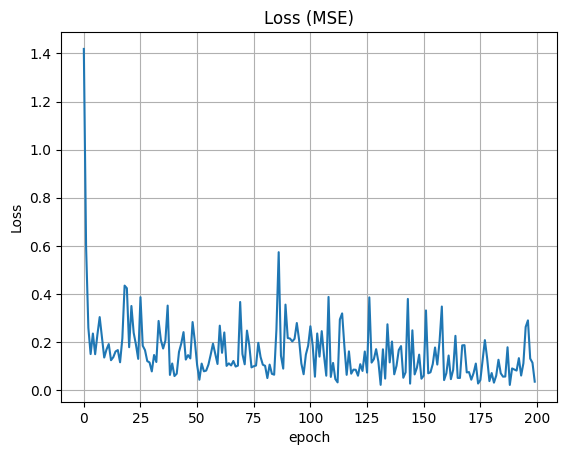

0.035233065485954285


In [ ]:
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Model_Standart(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.hidden_dim = 128
        self.features = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.LeakyReLU()            
        )
        self.output = nn.Linear(self.hidden_dim, 1)
        
    def forward(self, x):
        features = self.features(x)
        return self.output(features)

def train(model, train_loader, optimizer, n_epoch):
    loss_list = []
    for epoch in range(n_epoch):
        for x, y in train_loader:
            #print(x.shape, y.shape)
            optimizer.zero_grad()
            features = model.features(x)
            y_hat = model.output(features)
                
            loss_mse = nn.MSELoss()
            loss = loss_mse(y_hat, y)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())

    plt.figure()
    plt.plot(range(len(loss_list)), loss_list)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title("Loss (MSE)")
    plt.grid(True)
    plt.show()
    
    print(loss_list[-1])
    
def evaluate(model, val_loader, pe):
    model.eval()
    list_loss = []
    with torch.no_grad():
        for x, y in val_loader:
            y_pred = model(x)
            mse_loss = nn.MSELoss()
            loss = mse_loss(y_pred, y)
            list_loss.append(loss.item())
    
    plt.figure()
    plt.plot(range(len(list_loss)), list_loss)
    plt.xlim([0, 100])
    plt.ylim([min(list_loss), max(list_loss)])
    plt.legend([f"pe={pe}"])
    plt.ylabel('Loss')
    plt.title("Loss (MSE)")
    plt.grid(True)
    plt.show()
    print(f"mean error mse: {list_loss[-1]/len(list_loss)}")
        
if __name__ == "__main__":
    model = Model_Standart(4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
    train(model, train_loader, optimizer, 100)
    
   
    

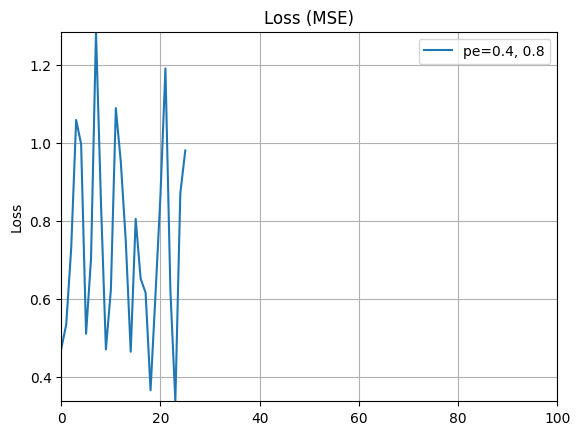

mean error mse: 0.037708557569063626


In [38]:
evaluate(model, val_loader, "0.4, 0.8")

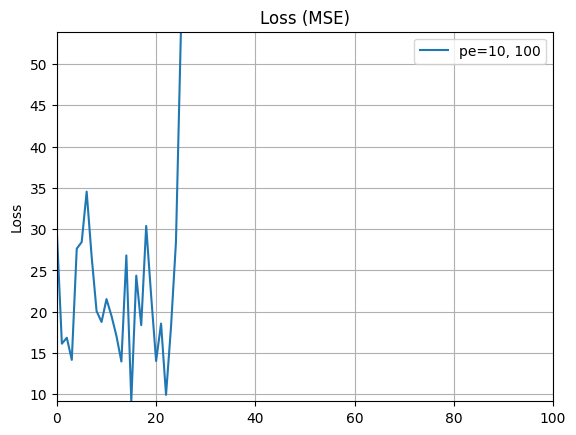

mean error mse: 2.073385532085712


In [39]:
evaluate(model, test_loader, "10, 100")

**Метод на основе изменения дисперсии дисперсии**

*Cпуриативные признаки* - ложные признаки работающие только в обучающих данных в определенных средах, но не в реальном мире

Diverge:  tensor([[ 1.0732,  0.5067, 26.2381, 27.1378],
        [ 1.3574,  1.4213, 21.5692, 22.7281],
        [ 1.1771,  1.0871, 24.8084, 20.9766],
        [ 1.3540,  0.7961, 12.8616, 11.4083]])
Instability:  tensor([1.9518e-02, 1.5369e-01, 3.5985e+01, 4.3965e+01])
Threshold:  tensor(18.0693)
torch.Size([128, 4])
Unstable weight:  tensor(20.2925, grad_fn=<SumBackward0>)
Diverge:  tensor([[ 1.0732,  0.5067, 26.2381, 27.1378],
        [ 1.3574,  1.4213, 21.5692, 22.7281],
        [ 1.1771,  1.0871, 24.8084, 20.9766],
        [ 1.3540,  0.7961, 12.8616, 11.4083],
        [ 0.4643,  1.3126, 30.5935, 29.1174]])
Instability:  tensor([ 0.1351,  0.1412, 44.0058, 47.6105])
Threshold:  tensor(22.0735)
torch.Size([128, 4])
Unstable weight:  tensor(20.2626, grad_fn=<SumBackward0>)
Diverge:  tensor([[ 1.0732,  0.5067, 26.2381, 27.1378],
        [ 1.3574,  1.4213, 21.5692, 22.7281],
        [ 1.1771,  1.0871, 24.8084, 20.9766],
        [ 1.3540,  0.7961, 12.8616, 11.4083],
        [ 0.4643,  1.3126,

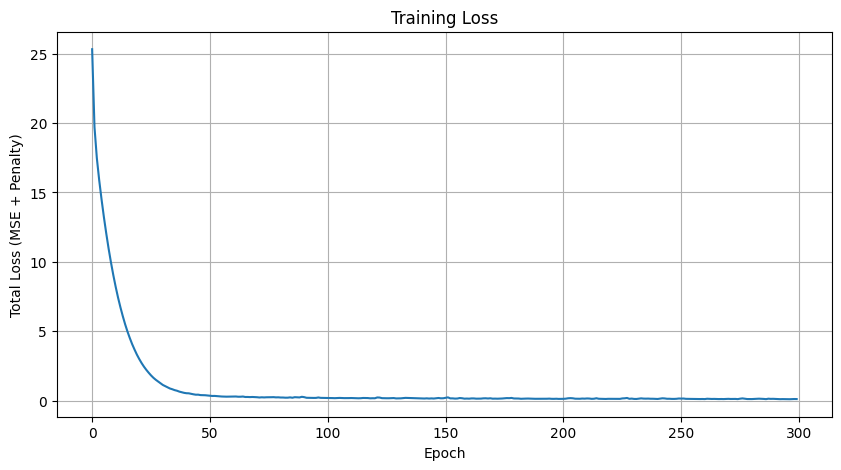


Final loss: 0.1050


In [ ]:
import collections

def train_with_instability_penalty(
    model, 
    train_loader, 
    optimizer, 
    n_epoch,
    lambda_=0.01,                 # сила штрафа
    history_len=50,               # длина истории батчей
    instability_percentile=75     # порог для определения "нестабильных" признаков
):
    """
    Функция обучения с добавлением в лосс штрафа за большие веса 
    у нестабильных входных признаков.
    
    """
    loss_list = []
    feature_variances_history = collections.deque(maxlen=history_len)
    
    min_history_for_penalty = 3

    for epoch in range(n_epoch):
        epoch_total_loss = 0
        epoch_mse_loss = 0
        epoch_penalty = 0
        
        for x, y in train_loader:
            optimizer.zero_grad()

            with torch.no_grad():
                batch_variances = torch.var(x, dim=0)
                feature_variances_history.append(batch_variances)

            y_hat = model(x)
            
            loss_mse = nn.MSELoss()(y_hat, y)
            

            instability_penalty = torch.tensor(0.0, device=x.device)
            if len(feature_variances_history) > min_history_for_penalty:
                history_tensor = torch.stack(list(feature_variances_history))
                
                print("Diverge: ", history_tensor)
                instability_scores = torch.var(history_tensor, dim=0)
                print("Instability: ", instability_scores)
                
                threshold = torch.quantile(instability_scores, q=instability_percentile / 100.0)
                print("Threshold: ", threshold)
                unstable_feature_indices = torch.where(instability_scores > threshold)[0]
                
                if unstable_feature_indices.numel() > 0:
                    first_layer_weights = model.features[0].weight
                    print(first_layer_weights.shape)
                    # (hidden_dim, input_dim)
                    unstable_weights = first_layer_weights[:, unstable_feature_indices]
                    
                    # Штраф - L2 норма (сумма квадратов) этих весов
                    instability_penalty = torch.sum(unstable_weights ** 2)
                    print("Unstable weight: ", instability_penalty)
            # 5. Итоговая функция потерь
            loss = loss_mse + lambda_ * instability_penalty
            
            loss.backward()
            optimizer.step()
            
            epoch_total_loss += loss.item()
            epoch_mse_loss += loss_mse.item()
            epoch_penalty += instability_penalty.item()

        avg_loss = epoch_total_loss / len(train_loader)
        avg_mse = epoch_mse_loss / len(train_loader)
        avg_penalty = epoch_penalty / len(train_loader)
        loss_list.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epoch} | Avg Total Loss: {avg_loss:.4f} | Avg MSE: {avg_mse:.4f} | Avg Penalty: {avg_penalty:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss_list)), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss (MSE + Penalty)')
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()
    
    print(f"\nFinal loss: {loss_list[-1]:.4f}")
    
    
if __name__ == '__main__':
    
    model_statistic = Model_Standart(4)
    optimizer = torch.optim.Adam(model_statistic.parameters(), lr=0.001)
    
    train_with_instability_penalty(
        model_statistic, 
        train_loader, 
        optimizer, 
        n_epoch=300,
        lambda_= 1, 
        history_len= 10,      
        instability_percentile=50  
    )

In [97]:
model_statistic.features[0].weight
print(torch.mean(model_statistic.features[0].weight[:,0]))
print(torch.mean(model_statistic.features[0].weight[:,3]))

tensor(-0.0016, grad_fn=<MeanBackward0>)
tensor(-0.0001, grad_fn=<MeanBackward0>)


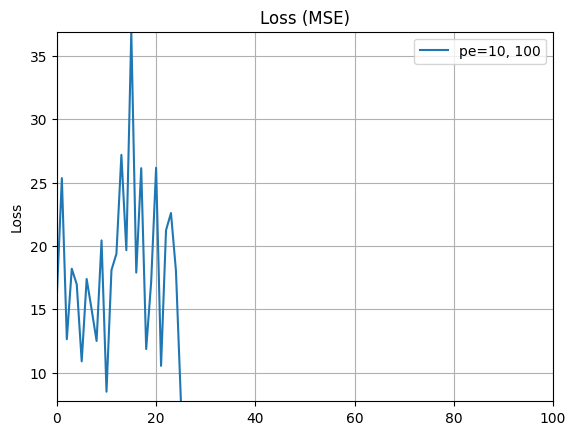

mean error mse: 0.29814762335557204


In [92]:
evaluate(model_statistic, test_loader, "10, 100")

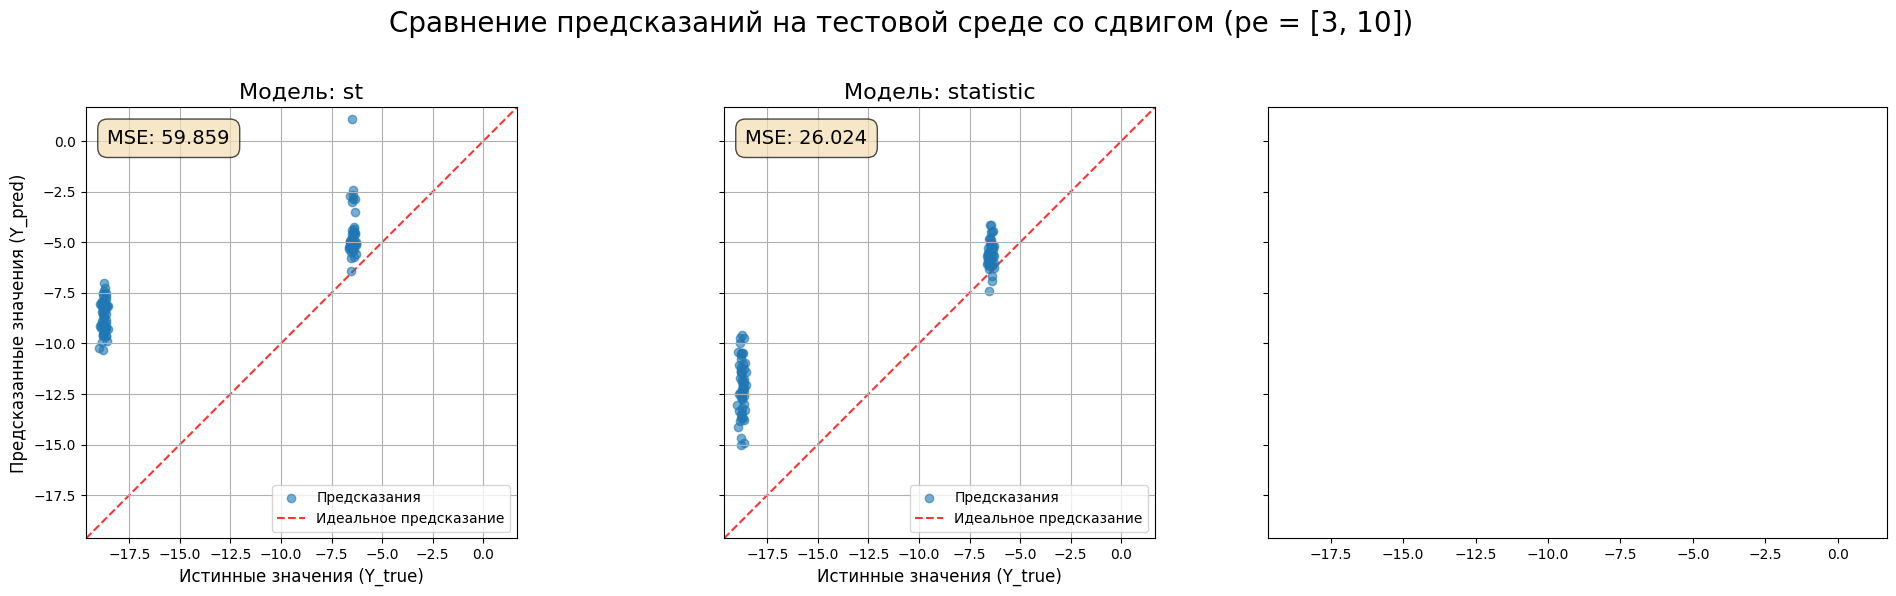

In [90]:
def plot_predictions_comparison(models, pe_test_value, n_samples=300):


    X, Y = next(iter(create_dataloader(pe_test_value, 100, 100)))
    predictions = {}
    for name, model in models:
        model.eval()
        with torch.no_grad():
            Y_pred = model(X)
        predictions[name] = Y_pred.numpy()
        
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
    fig.suptitle(f'Сравнение предсказаний на тестовой среде со сдвигом (pe = {pe_test_value})', fontsize=20)
    
    model_names = [name for name, model in models]
    
    for i, model_name in enumerate(model_names):
        ax = axes[i]
        y_pred = predictions[model_name]
        
        # График рассеяния
        ax.scatter(Y, y_pred, alpha=0.6, label='Предсказания')
        
        # Линия идеального предсказания
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'r--', alpha=0.8, zorder=0, label='Идеальное предсказание')
        ax.set_aspect('equal', 'box')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        ax.set_title(f'Модель: {model_name}', fontsize=16)
        ax.set_xlabel('Истинные значения (Y_true)', fontsize=12)
        if i == 0:
            ax.set_ylabel('Предсказанные значения (Y_pred)', fontsize=12)

        mse = torch.mean((Y - y_pred)**2)
        ax.text(0.05, 0.95, f'MSE: {mse:.3f}', 
                transform=ax.transAxes, fontsize=14, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))
        
        ax.legend()
        ax.grid(True)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
plot_predictions_comparison([("st", model), ("statistic", model_statistic)], [3, 10], n_samples=300)